# Лекция 11. Деревья решений. Случайный лес. Градиентный бустинг

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
titanic = pd.read_csv('/content/drive/MyDrive/Введение в ML ITHUB/lessons/data/titanic.csv')
titanic.head()

In [ ]:
#предобработка
titanic['Sex']=titanic['Sex'].map({'male':1,'female':0})

#кодирование категориальных признаков [Pclass,Embarked]
def encode_features(df,features):
  df_encode = pd.DataFrame()
  for f in features:
    ohe = OneHotEncoder()
    ohe_arr = ohe.fit_transform(df[[f]])
    ohe_df=pd.DataFrame(ohe_arr.toarray(), columns=ohe.get_feature_names_out())
    df_encode = pd.concat([df_encode,ohe_df],axis=1)
  return df_encode
enc_features = encode_features(titanic,['Pclass','Embarked'])
titanic_df = titanic[['Survived','Sex','Age','SibSp','Parch','Fare']]
titanic_df = pd.concat([titanic_df,enc_features],axis=1)
titanic_df=titanic_df.drop([titanic_df.columns[-1]],axis=1).dropna()

In [ ]:
#делим на X и Y
Y = titanic_df['Survived']
X = titanic_df.drop(['Survived'],axis=1)

In [11]:
X

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0
1,0,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0
2,0,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0
3,0,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,0.0,1.0
4,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,1.0,0.0
886,1,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,0.0,1.0
887,0,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0


## Деревья решений. Почему деревья должны что-то решать?

Они представляют собой иерархические древовидные структуры, состоящие из решающих правил вида «Если ..., то ...». Правила автоматически генерируются в процессе обучения на обучающем множестве и, поскольку они формулируются практически на естественном языке (например, «Если объём продаж более 1000 шт., то товар перспективный»), деревья решений как аналитические модели более вербализуемы и интерпретируемы, чем, скажем, нейронные сети.

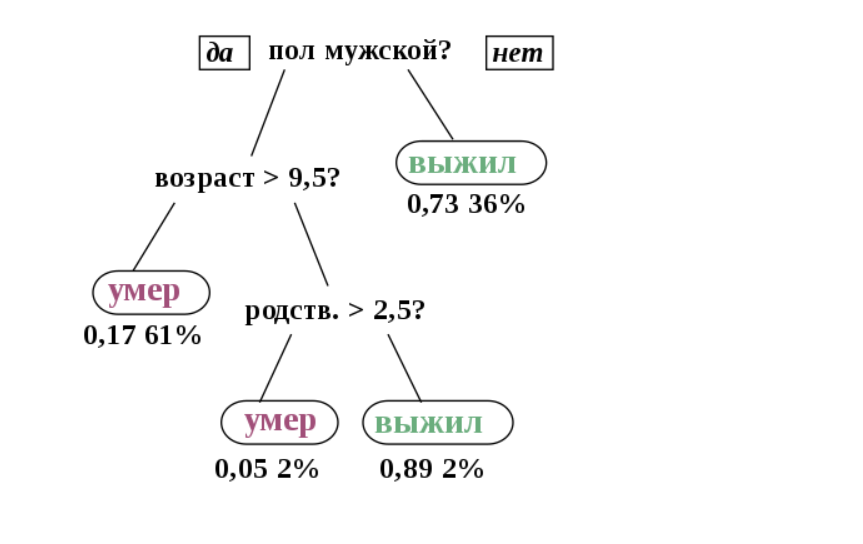

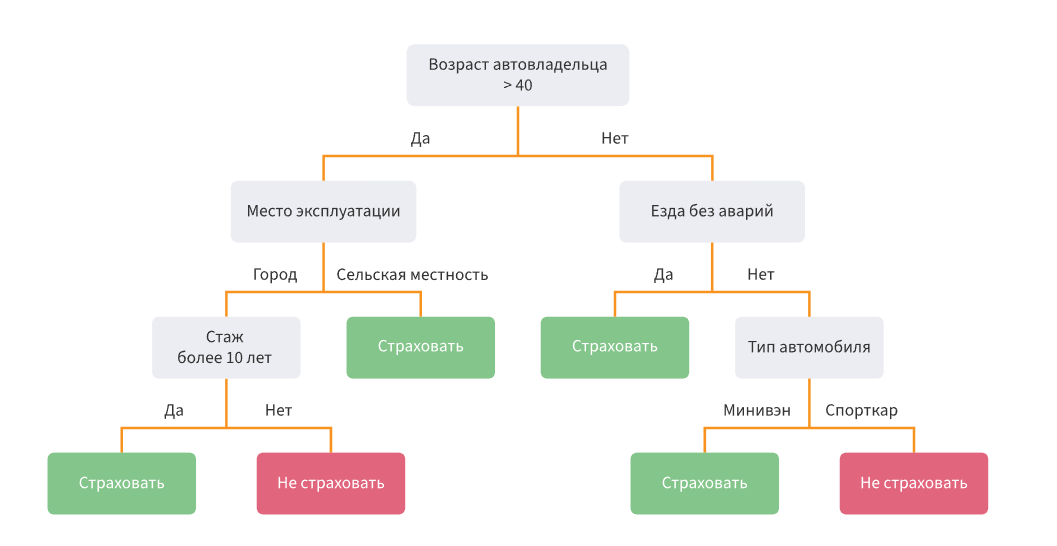

Основные этапы построения дерева
* Определите «лучший признак » в наборе данных для их разбиения. О том, как определить этот «лучший признак » поговорим позже.
* Разбейте данные на подмножества, которые будут содержать возможные значения для лучшего признака. Такое разбиение в основном определяет узел на дереве, то есть каждый узел — это разделенная точка, основанная на определенном признаке из наших данных.
* Рекурсивно сгенерируйте новые узлы дерева с помощью подмножества данных, созданных на 2 этапе. Продолжайте разбиение до тех пор, пока не достигните точки, на которой будет находится оптимизированная каким-то способом максимальная точность. Старайтесь минимизировать количество разбиений и узлов.

In [9]:
clf_tree = tree.DecisionTreeClassifier(max_depth=5)
clf_tree = clf_tree.fit(X[['Sex','Fare','Age','SibSp','Parch']],Y)

In [10]:
import graphviz 
dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                     feature_names=X[['Sex','Fare','Age','SibSp','Parch']].columns,  
                     class_names=['died','survived'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("titanic")

'titanic.pdf'

In [ ]:
#потестить на нескольких признаках

In [12]:
#тюнинг моделей
max_features = ['sqrt','log2',len(X.columns)]
max_depth = [3,5,7,10]
grid = dict(max_features=max_features,max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model =  tree.DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, Y) 

In [13]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805288 using {'max_depth': 3, 'max_features': 11}
0.755438 (0.068428) with: {'max_depth': 3, 'max_features': 'sqrt'}
0.762285 (0.059710) with: {'max_depth': 3, 'max_features': 'log2'}
0.805288 (0.046839) with: {'max_depth': 3, 'max_features': 11}
0.774511 (0.066731) with: {'max_depth': 5, 'max_features': 'sqrt'}
0.779154 (0.041538) with: {'max_depth': 5, 'max_features': 'log2'}
0.792182 (0.035487) with: {'max_depth': 5, 'max_features': 11}
0.776428 (0.049034) with: {'max_depth': 7, 'max_features': 'sqrt'}
0.781449 (0.039809) with: {'max_depth': 7, 'max_features': 'log2'}
0.793610 (0.041366) with: {'max_depth': 7, 'max_features': 11}
0.776428 (0.039652) with: {'max_depth': 10, 'max_features': 'sqrt'}
0.764189 (0.048441) with: {'max_depth': 10, 'max_features': 'log2'}
0.781403 (0.042218) with: {'max_depth': 10, 'max_features': 11}


# Случайный лес - Random Forest

Случайный лес – метод Машинного обучения (ML), использующий Ансамбль (Ensemble) Деревьев решений (Decision Tree) для задач Классификации (Classification). Каждое отдельное дерево в таком лесу дает предсказание класса, и набравший наибольшее количество голосов Класс (Class), становится предсказанием Модели (Model). Он использует Бэггинг (Bagging) и случайность признаков при построении каждого отдельного дерева, чтобы создать некоррелированный лес из деревьев, прогноз которого "комитетом" более точен, чем прогноз любого отдельного дерева.

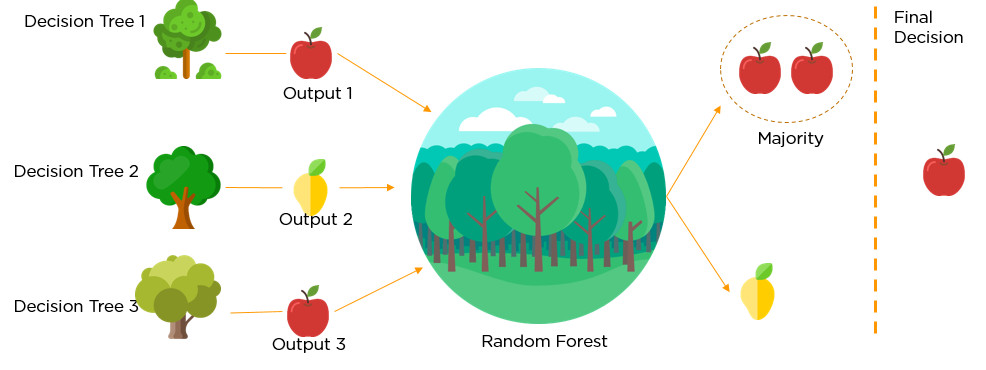

Фундаментальная концепция в основе случайного леса проста, но сильна — это мудрость толпы. Причина, по которой модель случайного леса работает так хорошо, заключается в том, что:

Большое число относительно некоррелированных деревьев, работающих совместно, будет превосходить любую из их отдельных составляющих.

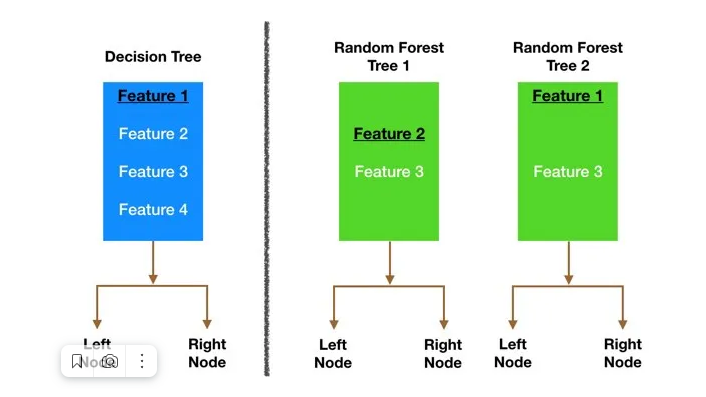

Случайность признака. В обычном дереве решений, когда нужно разделить узел, мы рассматриваем каждый возможный признак и выбираем тот, который сильнее делит значения в узлах. Напротив, каждое дерево в случайном лесу может выбирать только из случайного подмножества объектов. Это приводит к еще большей вариации между деревьями в модели и в конечном итоге к более слабой корреляции между деревьями и большему разнообразию.

Бэггинг. Деревья решений очень чувствительны к данным, на которых обучаются: небольшие изменения в наборе могут привести к значительно отличающимся древовидным структурам. Случайный лес использует это преимущество, позволяя каждому отдельному дереву произвольно выбирать данные с заменой, что приводит к различным деревьям. Этот процесс известен как беггинг.

In [14]:
#создание модели
model = RandomForestClassifier()

In [15]:
#тюнинг
n_estimators = [10, 100, 200] #количество деревьев
max_features = ['sqrt', 'log2',len(X.columns)]

In [16]:
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.790819 using {'max_features': 'log2', 'n_estimators': 10}
0.783764 (0.046425) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.788439 (0.040657) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.787969 (0.042915) with: {'max_features': 'sqrt', 'n_estimators': 200}
0.790819 (0.040215) with: {'max_features': 'log2', 'n_estimators': 10}
0.789365 (0.043032) with: {'max_features': 'log2', 'n_estimators': 100}
0.790799 (0.041735) with: {'max_features': 'log2', 'n_estimators': 200}
0.787533 (0.039857) with: {'max_features': 11, 'n_estimators': 10}
0.787487 (0.039142) with: {'max_features': 11, 'n_estimators': 100}
0.787937 (0.041218) with: {'max_features': 11, 'n_estimators': 200}


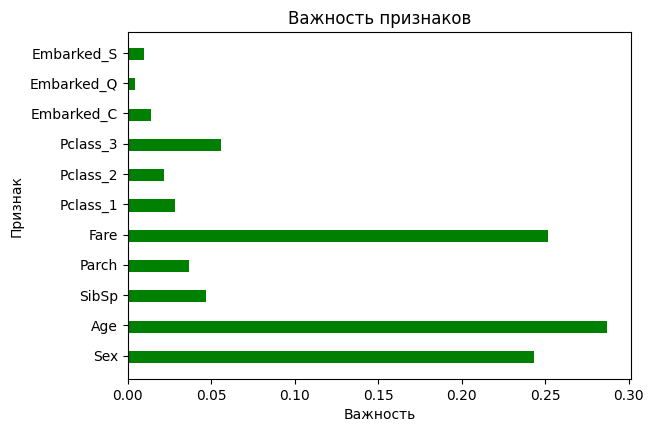

<Figure size 500x500 with 0 Axes>

In [17]:
#важность признаков
model_rf = RandomForestClassifier(n_estimators=100,max_features='log2')
model_rf.fit(X,Y)
col = X.columns
y = model_rf.feature_importances_
fig, ax = plt.subplots() 
width = 0.4 
ind = np.arange(len(y)) 
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [19]:
#из леса можно выдернуть каждое отдельное дерево и визуализировать его
estimator = model_rf.estimators_[5]

## Градиентный бустинг

Бустинг — это техника построения ансамблей, в которой предсказатели построены не независимо, а последовательно

Это техника использует идею о том, что следующая модель будет учится на ошибках предыдущей.

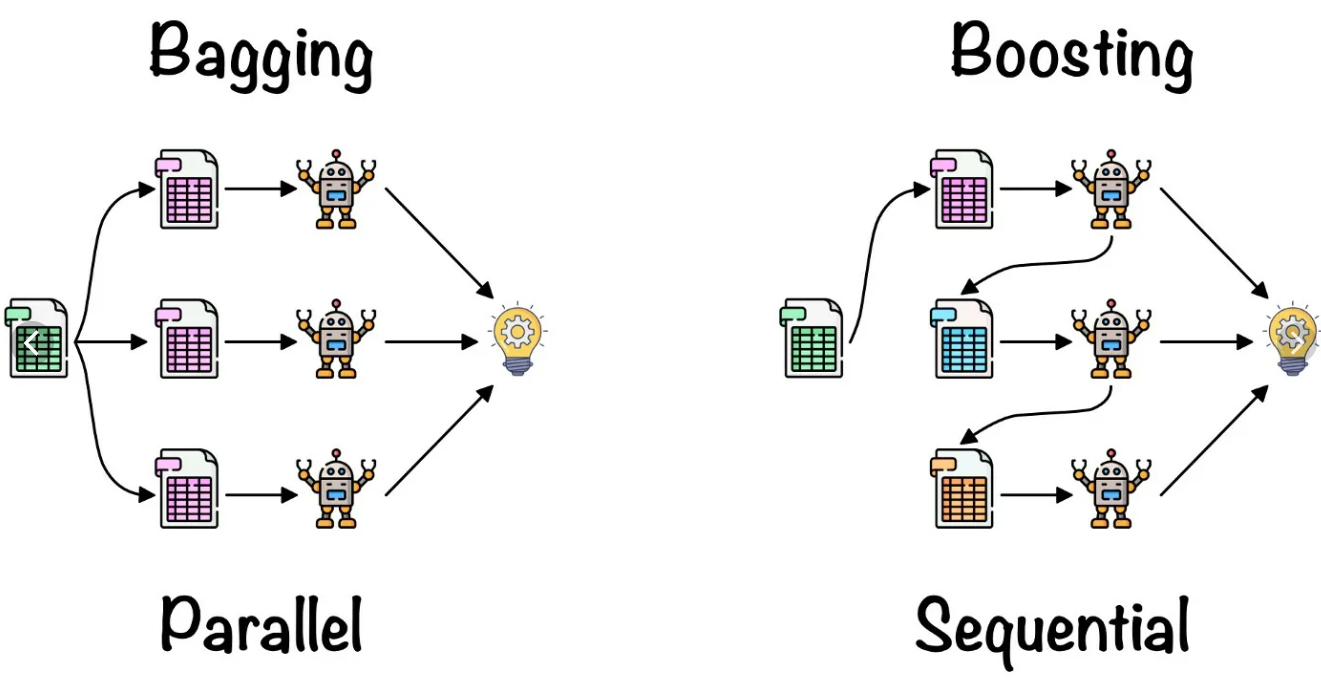

Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений.

In [20]:
model = GradientBoostingClassifier()
n_estimators = [10, 50, 100]
learning_rate = [0.001, 0.01, 0.1] # скорость обучения каждого дерева
subsample = [0.5, 0.7, 1.0] #подвыборка
max_depth = [3, 7, 9] #глубина деревьев
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.820136 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.593818 (0.002779) with: {'learning_rate': 0.001, 'max_dep

Также есть другие варианты реализации градиентного бустинга:
* XGBoost
* CatBoost

## ЛР Классификация

* найти набор данных, для которого МОЖНО РЕШИТЬ ЗАДАЧУ КЛАССИФИКАЦИИ
* выполнить предобработку (если необходимо) и стандартизацию данных
* построить минимум 3 разных модели классификации, используя минимум 2 разных алгоритма классификации
* на основании выбранной вами метрики выбрать лучшую модель
* для лучшей модели отобразить матрицу путаницы
* Доп.баллы за перевод в двумерное пространство с помощью PCA  и отрисовку графика